# Sparse sensing documentation

## Mathematical theory

The fundamental intuition behind the concept of sparse sensing is that a great number of physical phenomena admit a sparse representation in some alternative basis [1](https://doi.org/10.1017/9781108380690). The intrinsic sparsity of a physical phenomenon also means that it is possible to dramatically decrease the amount of measurements without losing important information on the system [2](https://doi.org/10.48550/arXiv.math/0410542).


The goal of a Sensor Placement for Reconstruction (SPR) model is to find the solution of the following linear system:

\begin{equation}
    \tag{1}
	\mathbf{y} = \mathbf{C} \mathbf{x}
	\label{y_Cx}
\end{equation}

where $\mathbf{y} \subset \mathbb{R}^s$ is the measurement vector, $\mathbf{x} \subset \mathbb{R}^n$ represents the state of the system and $\mathbf{C} \subset \mathbb{R}^{s,n}$ is the measurement matrix. 


The objective is to minimize the amount of sensors needed, that is $ n \gg s$, which means that the matrix $ \mathbf{C} $ is not invertible and the linear system admits infinite solutions.  Moreover, the linear problem in Eq. (\ref{y_Cx}) is generally ill-conditioned. As a result, linear methods such as least-squares regression cannot be applied to find an acceptable solution.


However, if the system admits a sparse representation in a new basis, we can consider that $ \mathbf{x} \approx \mathbf{U}_{q} \mathbf{a}_q$ where $\mathbf{U}_q \subset \mathbb{R}^{n,q}$ represents the $q$-order truncation of the transforming basis and $\mathbf{a}_q$ is the projection of $\mathbf{x}$ onto the new truncated basis.


Depending on the system considered, a different number of decomposition techniques can be applied to recover the new basis from the data. An obvious choice is to use the Proper Orthogonal Decomposition (POD) [3](https://doi.org/10.1146/annurev.fl.25.010193.002543), also known as Principal Component Analysis (PCA) or Karhunen-Loeve transform (KLT), because it guarantees that the $q$-order truncation is the one that minimizes the $l_2$ norm reconstruction error. The POD can be achieved by applying the Singular Value Decomposition (SVD) to the dataset:


\begin{equation}
	\mathbf{X} = \mathbf{U} \mathrm{\boldsymbol{\Sigma}} \mathbf{V}^T
    \label{eq_SVD}
\end{equation}


where $\mathbf{X} \subset \mathbb{R}^{n,p}$ represents the data matrix to be decomposed, $\mathbf{U} \subset \mathbb{R}^{n,p}$ and $\mathbf{V} \subset \mathbb{R}^{p,p}$ are matrices which form an orthonormal basis for the column and row spaces of $\mathbf{X}$, and $\mathrm{\boldsymbol{\Sigma}} \subset \mathbb{R}^{p,p}$ is the diagonal matrix which contains the singular values of $\mathbf{X}$. The singular values are the square root of the eigenvalues of the correlation matrix $\mathbf{S} = \mathbf{X}^T \mathbf{X}$, and they express the amount of variance that each column (mode) of $\mathbf{U}$ is able to capture with respect to the original data matrix.  


If we assemble $p$ vectors $\mathbf{x}$ as column vectors of a data matrix $\mathbf{X}$, we can then use the SVD to find the transforming basis $\mathbf{U}_q$ by discarding the last $p-q$ columns of $\mathbf{U}$. 


By introducing $ \mathbf{x} = \mathbf{U}_{q} \mathbf{a}_q$, the linear system in Eq. (\ref{y_Cx}) can then be written as:

\begin{equation}
    \tag{2}
	\mathbf{y} = \mathrm{\boldsymbol{\Theta}} \mathbf{a}_q
    \label{y_thetax}
\end{equation}

where $ \mathrm{\boldsymbol{\Theta}} = \mathbf{C} \mathbf{U}_q$. In order to find a solution for Eq. (\ref{y_thetax}), the matrix $\mathbf{C}$ has to be constructed such that $\mathrm{\boldsymbol{\Theta}}$ is as well-conditioned as possible. This objective can be reached by making sure that $\mathbf{C}$ is incoherent with respect to $\mathbf{U}_q$, which means that the rows of $\mathbf{C}$ should not be correlated with the columns of  $\mathbf{U}_q$ [4](https://doi.org/10.1109/MSP.2007.914731). 

### Optimal placement using QR decomposition with column pivoting
A popular approach to construct the measurement matrix is to use random sampling. This technique is computationally inexpensive, and a random measurement has a high probability of being incoherent with respect to the transforming basis [4](https://doi.org/10.1109/MSP.2007.914731). However, this technique does not produce an optimized placement of sensors, thus the number of sensors required is far from the theoretical minimum.


Another technique to construct the measurement matrix is to select the sensors' position based on the QR decomposition with column pivoting (QRCP) [5](https://doi.org/10.1109/MCS.2018.2810460). The QRCP is a decomposition technique in which a matrix $\mathbf{A}\subset \mathbb{R}^{q,n}$ is factorized into an orthogonal matrix $\mathbf{Q} \subset \mathbb{R}^{q,q}$ and an upper rectangular matrix $\mathbf{R}\subset \mathbb{R}^{q,n}$:

\begin{equation}
	\mathbf{A}\mathbf{P} = \mathbf{Q}\mathbf{R}
\end{equation}

The matrix $\mathbf{P}$ is a permutation matrix which is chosen so that the diagonal elements of $\mathbf{R}$ are not increasing. QRCP is usually employed as a rank revealing method. In our case, the pivots are used to construct the measurement matrix from the transforming basis:

\begin{equation}
	\mathbf{U}_q^T \mathbf{C}^T = \mathbf{Q}\mathbf{R}
    \label{optimal_C}
\end{equation}

The QRCP is able to provide $q$ sensors which best sample the transforming basis $\mathbf{U}_q$. 


### Optimal placement using the greedy entropy maximization algorithm



## Example

The first cell is used to import the packages and the dataset, plus some utilities for plotting

In [1]:
import numpy as np
from gpr import GPR
from sparse_sensing import SPR
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri

path = '../data/ROM/'

# This is a n x m matrix where n = 165258 is the number of cells times the number of features
# and m = 41 is the number of simulations.
X_train = np.load(path + 'X_2D_train.npy')

# This is a n x 4 matrix containing the 4 testing simulations
X_test = np.load(path + 'X_2D_test.npy')

features = ['T', 'CH4', 'O2', 'CO2', 'H2O', 'H2', 'OH', 'CO', 'NOx']
n_features = len(features)

# This is the file containing the x,z positions of the cells
xz = np.load(path + 'xz.npy')
n_cells = xz.shape[0]

# This reads the files containing the parameters (D, H2, phi) with which 
# the simulation were computed
P_train = np.genfromtxt(path + 'parameters_train.csv', delimiter=',', skip_header=1)
P_test = np.genfromtxt(path + 'parameters_test.csv', delimiter=',', skip_header=1)

# Load the outline the mesh (for plotting)
mesh_outline = np.genfromtxt(path + 'mesh_outline.csv', delimiter=',', skip_header=1)

#---------------------------------Plotting utilities--------------------------------------------------
def sample_cmap(x):
    return plt.cm.jet((np.clip(x,0,1)))

def plot_sensors(xz_sensors, features, mesh_outline):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot(mesh_outline[:,0], mesh_outline[:,1], c='k', lw=0.5, zorder=1)
    
    features_unique = np.unique(xz_sensors[:,2])
    colors = np.zeros((features_unique.size,4))
    for i in range(colors.shape[0]):
        colors[i,:] = sample_cmap(features_unique[i]/len(features))
        
    for i, f in enumerate(features_unique):
        mask = xz_sensors[:,2] == f
        ax.scatter(xz_sensors[:,0][mask], xz_sensors[:,1][mask], color=colors[i,:], 
                   marker='x', s=15, lw=0.5, label=features[int(f)], zorder=2)

    
    ax.set_xlabel('$x (\mathrm{m})$', fontsize=8)
    ax.set_ylabel('$z (\mathrm{m})$', fontsize=8)
    eps = 1e-2
    ax.set_xlim(-eps, 0.35)
    ax.set_ylim(-0.15,0.7+eps)
    ax.set_aspect('equal')
    ax.legend(fontsize=8, frameon=False, loc='center right')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    wid = 0.3
    ax.xaxis.set_tick_params(width=wid)
    ax.yaxis.set_tick_params(width=wid)
    ax.set_xticks([0., 0.18, 0.35])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.show()

def plot_contours_tri(x, y, zs, cbar_label=''):
    triang = tri.Triangulation(x, y)
    triang_mirror = tri.Triangulation(-x, y)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,6))
    
    z_min = np.min(zs)
    z_max = np.max(zs)
   
    n_levels = 12
    levels = np.linspace(z_min, z_max, n_levels)
    cmap_name= 'inferno'
    titles=['Original CFD','Predicted']
    
    for i, ax in enumerate(axs):
        if i == 0:
            ax.tricontourf(triang_mirror, zs[i], levels, vmin=z_min, vmax=z_max, cmap=cmap_name)
        else:
            ax.tricontourf(triang, zs[i], levels, vmin=z_min, vmax=z_max, cmap=cmap_name)
            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 
        
        ax.set_aspect('equal')
        ax.set_title(titles[i])
        ax.set_xlabel('$x (\mathrm{m})$')
        if i == 0:
            ax.set_ylabel('$z (\mathrm{m})$')
    
    fig.subplots_adjust(bottom=0., top=1., left=0., right=0.85, wspace=0.02, hspace=0.02)
    start = axs[1].get_position().bounds[1]
    height = axs[1].get_position().bounds[3]
    
    cb_ax = fig.add_axes([0.9, start, 0.05, height])
    cmap = mpl.cm.get_cmap(cmap_name, n_levels)
    norm = mpl.colors.Normalize(vmin=z_min, vmax=z_max)
    
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cb_ax, 
                orientation='vertical', label=cbar_label)
    
    plt.show()


## Optimal sensor placement

In this cell, we use the function `optimal_placement()` to compute the optimal sensor placement matrix C using the QRCP algorithm.

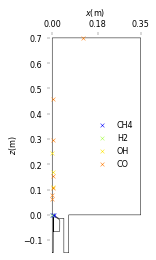

In [2]:
spr = SPR(X_train, n_features) # Create the spr object

# Compute the optimal measurement matrix using qr decomposition
n_sensors = 14
C_qr = spr.optimal_placement(select_modes='number', n_modes=n_sensors)

# Get the sensors positions and features
xz_sensors = np.zeros((n_sensors, 4))
for i in range(n_sensors):
    index = np.argmax(C_qr[i,:])
    xz_sensors[i,:2] = xz[index % n_cells, :]
    xz_sensors[i,2] = index // n_cells

plot_sensors(xz_sensors, features, mesh_outline)



In this cell, we use the same function `optimal_placement()` but we employ the greedy entropy maximization algorithm to find the optimal sensors.

In [ ]:
# Compute the optimal measurement matrix using gem decomposition
n_sensors = 14
C_gem = spr.optimal_placement(calc_type='entropy', n_sensors=n_sensors, n_modes=99.5, verbose=True)

# Get the sensors positions and features
xz_sensors = np.zeros((n_sensors, 4))
for i in range(n_sensors):
    index = np.argmax(C_gem[i,:])
    xz_sensors[i,:2] = xz[index % n_cells, :]
    xz_sensors[i,2] = index // n_cells

plot_sensors(xz_sensors, features, mesh_outline)

The placement and choice of sensors is similar to the QRCP choice. However, the advantage of the GEM algorithm is that we can exclude some regions of the domain which could be unaccessible for measurements. In the next cell we use the GEM algorithm to find the optimal set of sensor with the constrain that the axial position of the sensor must be lower then 0.5 meters.

In [ ]:
mask_z = xz[:,1] < 0.5
mask_z = np.tile(mask_z, n_features)
C_gem = spr.optimal_placement(calc_type='entropy', n_sensors=13, mask=mask_z, n_modes=99.5, verbose=True)

# Get the sensors positions and features
xz_sensors = np.zeros((n_sensors, 4))
for i in range(n_sensors):
    index = np.argmax(C_gem[i,:])
    xz_sensors[i,:2] = xz[index % n_cells, :]
    xz_sensors[i,2] = index // n_cells

plot_sensors(xz_sensors, features, mesh_outline)

## Sparse Placement for Reconstruction

In this cell, we use the C matrix to sample a test case, then we use the `SPR()` function to predict the state of the system given few (14) measurements. 

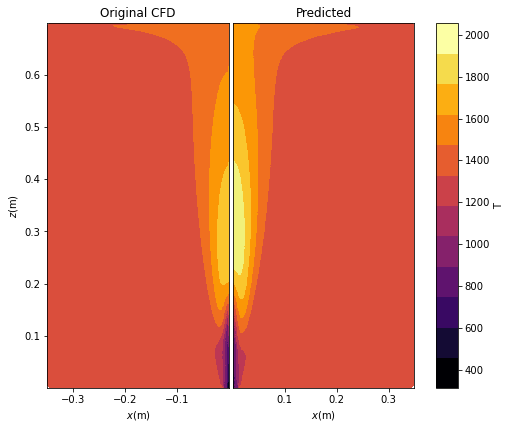

In [3]:
# Sample a test simulation using the optimal qr matrix
y_qr = np.zeros((n_sensors,2))
y_qr[:,0] = C_qr @ X_test[:,3]

for i in range(n_sensors):
    y_qr[i,1] = np.argmax(C_qr[i,:]) // n_cells

# Fit the model and predict the low-dim vector (ap) and the high-dim solution (xp)
ap, xp = spr.fit_predict(C_qr, y_qr)

# Select the feature to plot
str_ind = 'T'
ind = features.index(str_ind)

plot_contours_tri(xz[:,0], xz[:,1], [X_test[ind*n_cells:(ind+1)*n_cells, 3], 
                xp[ind*n_cells:(ind+1)*n_cells]], cbar_label=str_ind)